# Table 2 - reconstruction

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('valid-experiments.csv')
# df.columns

In [14]:
def format_latex(df, highlight_max_cols=None, highlight_min_cols=None, round_digits=3, significants=None):
    formatted_df = df.copy()
    highlight_max_cols = highlight_max_cols or []
    highlight_min_cols = highlight_min_cols or []

    for col in df.columns:
        col_values = df[col]

        if col in highlight_max_cols:
            top_two = col_values.nlargest(2).values

            def format_cell(val):
                if val == top_two[0]:
                    return f"\\textbf{{{val:.{round_digits}f}}}"
                elif val == top_two[1]:
                    return f"\\underline{{{val:.{round_digits}f}}}"
                else:
                    return f"{val:.{round_digits}f}"

        elif col in highlight_min_cols:
            bottom_two = col_values.nsmallest(2).values

            def format_cell(val):
                if val == bottom_two[0]:
                    return f"\\textbf{{{val:.{round_digits}f}}}"
                elif val == bottom_two[1]:
                    return f"\\underline{{{val:.{round_digits}f}}}"
                else:
                    return f"{val:.{round_digits}f}"
        else:
            def format_cell(val):
                return f"{val}"

        formatted_df[col] = col_values.apply(format_cell)

    return formatted_df

In [15]:
def generate_recommendations_table(df):
    records = {}

    for i, row in df.iterrows():

            row_key = (row['embedding_dim'], row['top_k'])
            metrics = {
                "$NDCG_{com}$": row['NDCG20_com'],
                "$NDCG_{min}$": row['NDCG20_min'],
                "$NDCG_{mean}$": row['NDCG20/mean'],
                "Popularity": row['Popularity/mean'],
            }

            records[row_key] = metrics

    df = pd.DataFrame.from_dict(records, orient="index")
    df.index.names = ["Dimensions", "TopK"]

    # Sort and reindex columns by dataset then metric
    df = df.sort_index(axis=1, level=[0, 1]).sort_values(
        by=["Dimensions", "TopK"]
    )
    
    columns = ["$NDCG_{com}$", "$NDCG_{min}$", "$NDCG_{mean}$", "Popularity"]
    df = df[columns]
    
    return df.reset_index()

In [16]:
filterr = (df['group_type'] == 'sim') & (df['SAE_fusion_strategy'] == 'average') & (df['topk_inference'] == True)
df2 = df[filterr]
print(f"length: {len(df2)}")

table2 = generate_recommendations_table(df2)
table2

length: 9


,Dimensions,TopK,$NDCG_{com}$,$NDCG_{min}$,$NDCG_{mean}$,Popularity
0,1024,32,0.630638,0.550552,0.694563,0.504823
1,1024,64,0.632972,0.553457,0.696406,0.503572
2,1024,128,0.632924,0.553365,0.696549,0.500371
3,2048,32,0.630478,0.550292,0.695177,0.506356
4,2048,64,0.631139,0.552214,0.695301,0.502733
5,2048,128,0.633400,0.553483,0.696734,0.499338
6,4096,32,0.628930,0.550490,0.694522,0.507356
7,4096,64,0.629333,0.550241,0.694369,0.501466
8,4096,128,0.630406,0.552233,0.695319,0.498307


In [17]:
formatted_table = format_latex(
    table2,
    highlight_max_cols=["$NDCG_{com}$", "$NDCG_{min}$", "$NDCG_{mean}$"],
    highlight_min_cols=["Popularity"],
    round_digits=3
)

formatted_table.to_latex(
    "table_recommend.tex",
    index=False,
    float_format="%.3f",
    bold_rows=True,
    column_format="ll|cccc",
    escape=False,
    caption = (
        "UPGRADE Table2: Table of recommendation metrics for SAGEA with Avg aggregation function. "
    ),
    label="tab:recommendations"
)

# Heatmap for Table 2

/var/folders/11/x3r2lw756bs10f4yq3hp5cqh0000gn/T/ipykernel_62429/3233901049.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
/var/folders/11/x3r2lw756bs10f4yq3hp5cqh0000gn/T/ipykernel_62429/3233901049.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
/var/folders/11/x3r2lw756bs10f4yq3hp5cqh0000gn/T/ipykernel_62429/3233901049.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(

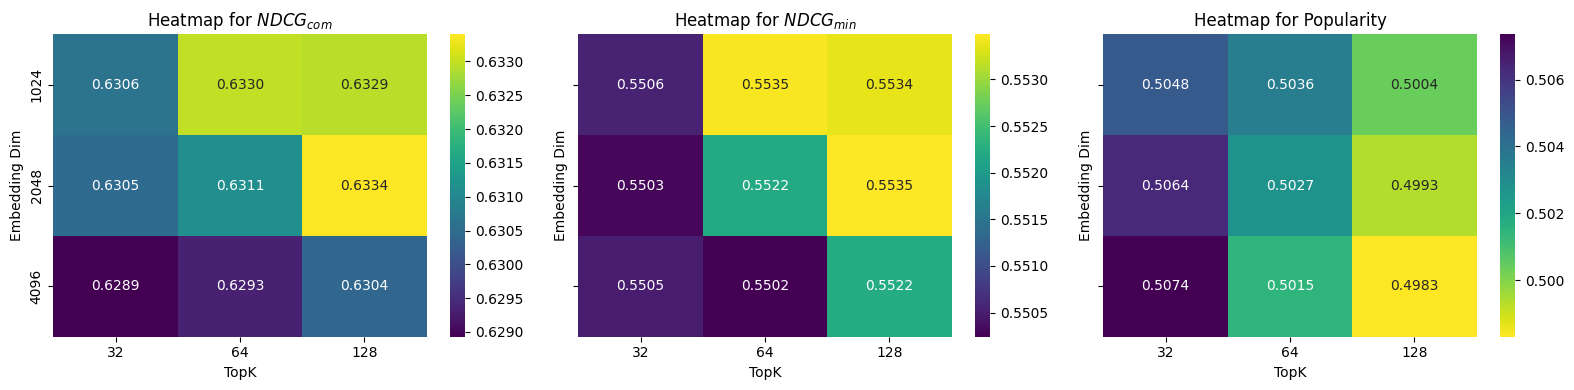

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

dims = [1024, 2048, 4096]
ks = [32, 64, 128]
metrics = ["$NDCG_{com}$", "$NDCG_{min}$", "Popularity"]

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for i, metric in enumerate(metrics):
    matrix = np.zeros((len(dims), len(ks)))
    for dim in dims:
        for k in ks:
            matrix[dims.index(dim), ks.index(k)] = table2.loc[
                (table2['Dimensions'] == dim) & (table2['TopK'] == k),
                metric
            ].values[0]
    df_temp = pd.DataFrame(matrix, index=dims, columns=ks)
    df_temp.index.name = "Embedding Dim"
    df_temp.columns.name = "TopK"
    cmap = cm.get_cmap("viridis")
    if metric == "Popularity":
        cmap = cmap.reversed()
    sns.heatmap(df_temp, annot=True, fmt=".4f", ax=ax[i], cmap=cmap)
    ax[i].set_title(f"Heatmap for {metric}")
    
fig.tight_layout()
plt.savefig("heatmap_sizes.png", dpi=300, bbox_inches='tight')

# Table 3 - overall results

In [23]:
aggregation_mapping = {
    "average": "Avg",
    "max": "Max",
    "common_features": "ComF",
    "wcom": "WCom",
    "topk": "TopK",
}

def get_method_name(row):
    method = row['recommender_strategy']
    if method == "SAE":
        aggregation = row['SAE_fusion_strategy']
        method += "-" + aggregation_mapping.get(aggregation, aggregation)
    return method.replace('_', '-')

def generate_table3(df):
    records = {}
    
    for i, row in df.iterrows():
        method = get_method_name(row)
        group_type = row['group_type']
        metrics = {
                (group_type, "$NDCG_{com}$"): row['NDCG20_com'],
                (group_type, "$NDCG_{min}$"): row['NDCG20_min'],
                (group_type, "$NDCG_{mean}$"): row['NDCG20/mean'],
                # (group_type, "Popularity"): row['Popularity/mean'],
            }
        if method not in records:
            records[method] = {}
        records[method].update(metrics)

    df = pd.DataFrame.from_dict(records, orient="index")
    df.index.names = ["Approach"]

    # Sort and reindex columns by dataset then metric
    df = df.sort_index(axis=1, level=[0, 1]).sort_values(
        by=["Approach"], ascending=False
    )
    
    dataset_order = ["sim", "random", "outlier"]
    metric_order = ["$NDCG_{com}$", "$NDCG_{min}$", "$NDCG_{mean}$"]#, "Popularity"]

    cols = df.columns
    cols = sorted(
        cols,
        key=lambda x: (
            dataset_order.index(x[0]) if x[0] in dataset_order else len(dataset_order),
            metric_order.index(x[1]) if x[1] in metric_order else len(metric_order)
        )
    )
    df = df[cols]

    return df.reset_index()

In [24]:
significance = pd.read_csv('significance.csv')
significance.head()

,Group Type,Metric,Strategy,Value,p-value,Significant
0,random,$NDCG_{mean}$,SAE-TopK,0.691774,NaN,False
1,sim,Popularity,ELSA-INT,0.425843,NaN,False
2,outlier,$NDCG_{com}$,SAE-TopK,0.542673,NaN,False
3,outlier,$NDCG_{min}$,SAE-TopK,0.494361,0.451111,False
4,outlier,$NDCG_{min}$,SAE-Max,0.494688,NaN,False


In [27]:
df3 = pd.read_csv('test-experiments.csv')
table3 = generate_table3(df3)

highlight_max_cols = []
highlight_min_cols = []
for ttype in ["sim", "random", "outlier"]:
    highlight_max_cols.extend([(ttype, "$NDCG_{com}$"), (ttype, "$NDCG_{min}$"), (ttype, "$NDCG_{mean}$")])
    # highlight_min_cols.append((ttype, "Popularity"))

formatted_table3 = format_latex(
    table3,
    highlight_max_cols=highlight_max_cols,
    highlight_min_cols=highlight_min_cols,
    round_digits=3
)

def add_significance(df, significance):
    for i, row in df.iterrows():
        for ttype in ["sim", "random", "outlier"]:
            for metric in ["$NDCG_{com}$", "$NDCG_{min}$", "$NDCG_{mean}$"]:#, "Popularity"]:
                filterr = (significance['Strategy'] == row['Approach'].values[0]) & (significance['Metric'] == metric) & (significance['Group Type'] == ttype)

                is_significant = significance[filterr]['Significant'].values and significance[filterr]['Significant'].values[0]
                if is_significant:
                    df.at[i, (ttype, metric)] = f"{df.at[i, (ttype, metric)]}^*"

add_significance(formatted_table3, significance)

formatted_table3.to_latex(
    "table_overall.tex",
    index=False,
    float_format="%.3f",
    bold_rows=True,
    column_format="l|cccc|cccc|cccc",
    escape=False,
    caption="UPGRADE - Table showing the performance of different recommendation approaches on the Movielens dataset.",
    label="tab:overall"
)

formatted_table3


Approach                sim                                        \
                   $NDCG_{com}$       $NDCG_{min}$      $NDCG_{mean}$   
0   SAE-WCom            0.630^*            0.552^*            0.698^*   
1   SAE-TopK     \textbf{0.639}     \textbf{0.558}  \underline{0.703}   
2    SAE-Max            0.621^*            0.549^*            0.693^*   
3   SAE-ComF            0.592^*            0.522^*            0.673^*   
4    SAE-Avg  \underline{0.637}  \underline{0.558}            0.703^*   
5    POPULAR            0.388^*            0.354^*            0.515^*   
6        MPL            0.477^*            0.461^*            0.615^*   
7        LMS            0.620^*            0.536^*            0.674^*   
8       GFAR            0.560^*            0.517^*            0.657^*   
9   EPFuzzDA            0.631^*            0.553^*            0.694^*   
10  ELSA-INT            0.500^*            0.444^*            0.633^*   
11      ELSA            0.615^*            0.530^*            0.697^*   
12       ADD              0.637              0.557     \textbf{0.704}   

               random                                          \
         $NDCG_{com}$       $NDCG_{min}$        $NDCG_{mean}$   
0             0.625^*            0.529^*              0.685^*   
1      \textbf{0.635}     \textbf{0.538}       \textbf{0.692}   
2             0.622^*            0.535^*              0.682^*   
3             0.558^*            0.487^*              0.639^*   
4             0.632^*  \underline{0.537}              0.689^*   
5             0.466^*            0.410^*              0.580^*   
6             0.411^*            0.410^*              0.570^*   
7             0.607^*            0.497^*              0.645^*   
8             0.507^*            0.476^*              0.619^*   
9             0.624^*            0.533^*              0.677^*   
10            0.422^*            0.362^*              0.579^*   
11            0.590^*            0.488^*              0.676^*   
12  \underline{0.633}            0.535^*  \underline{0.690}^*   

                outlier                                          
           $NDCG_{com}$       $NDCG_{min}$        $NDCG_{mean}$  
0               0.518^*            0.467^*              0.659^*  
1        \textbf{0.543}  \underline{0.494}       \textbf{0.672}  
2               0.519^*     \textbf{0.495}              0.651^*  
3               0.403^*            0.397^*              0.564^*  
4   \underline{0.524}^*            0.481^*  \underline{0.663}^*  
5               0.436^*            0.412^*              0.594^*  
6               0.257^*            0.303^*              0.484^*  
7               0.418^*            0.400^*              0.559^*  
8               0.369^*            0.414^*              0.560^*  
9               0.481^*            0.466^*              0.619^*  
10              0.120^*            0.129^*              0.403^*  
11              0.382^*            0.345^*              0.589^*  
12              0.520^*            0.475^*              0.661^*

## Test if the 2048, 128 model is significantly better than the 1024, 64 and 102, 128 models

In [6]:
import mlflow

mlflow.set_tracking_uri("file:///Users/vitkostejn/school/diploma_thesis/code/mlruns")

runs = mlflow.search_runs(
    experiment_ids=["523100174176986081"],
    filter_string="params.note = 'valid-significance'",
    output_format="list"
)
print(f"Number of runs: {len(runs)}")
for run in runs:
    print(f"Dims: {run.data.params['embedding_dim']}, TopK: {run.data.params['top_k']}, NDCG: {run.data.metrics['NDCG20_com']}")

Number of runs: 3
Dims: 2048, TopK: 128, NDCG: 0.6333997249603271
Dims: 1024, TopK: 64, NDCG: 0.6329721212387085
Dims: 1024, TopK: 128, NDCG: 0.6329240798950195


In [9]:
import pickle

def get_metric_data(run, metric='NDCG20'):
    artifact_path = run.info.artifact_uri.replace('file://', '') + '/logs.pkl'
    with open(artifact_path, 'rb') as f:
        data = pickle.load(f)
    return data[metric]

In [11]:
from scipy import stats

best_run = [run for run in runs if run.data.params['embedding_dim'] == '2048' and run.data.params['top_k'] == '128'][0]
best_run_com = get_metric_data(best_run, metric='Group_NDCG')
best_run_min = get_metric_data(best_run, metric='User_NDCG_Mins')

for run in [run for run in runs if run != best_run]:
    com_data = get_metric_data(run, metric='Group_NDCG')
    min_data = get_metric_data(run, metric='User_NDCG_Mins')
    print(f"Run: {run.data.params['embedding_dim']}, {run.data.params['top_k']}")
    t_stat, p_value = stats.ttest_rel(best_run_com, com_data, alternative='greater')
    print(f"  NDCG Com: t-statistic = {t_stat}, p-value = {p_value}")
    t_stat, p_value = stats.ttest_rel(best_run_min, min_data, alternative='greater')
    print(f"  NDCG Min: t-statistic = {t_stat}, p-value = {p_value}")

Run: 1024, 64
  NDCG Com: t-statistic = [0.33668557], p-value = [0.36821234]
  NDCG Min: t-statistic = 0.025783630785162562, p-value = 0.4897175337768777
Run: 1024, 128
  NDCG Com: t-statistic = [0.46038106], p-value = [0.32267147]
  NDCG Min: t-statistic = 0.15524081896910658, p-value = 0.4383314146620827
